In [1]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成

In [2]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#ハイパラ関連
#モデル名
model_size=7
model_size=13
model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=16
lora_alpha=16
bit=16
bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
gradient_checkpointing = False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [5]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [6]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

Using 4-bit mode


Loading checkpoint shards: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


# データセットの生成

In [ ]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [ ]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [ ]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 9198.04 examples/s]


In [ ]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [ ]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.422000
200,1.072400
300,1.017600
400,0.971400


OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 86.62 MiB is free. Including non-PyTorch memory, this process has 79.04 GiB memory in use. Of the allocated memory 77.58 GiB is allocated by PyTorch, and 975.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# モデルによる物性値の予測

In [ ]:

import re
import torch
import gc
from IPython.display import clear_output
model.eval()
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       max_tokens=300):
    gc.collect()
    torch.cuda.empty_cache()

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Predicted melting point:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value



In [ ]:

random.seed(0)
prediction_results={}

#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=3  # 値を返さなかったときの再試行の最大数

res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [01:10<57:25, 70.31s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C.
- The tetramethylcyclopentyl group is a bulky substituent that increases the molecular weight and provides steric hindrance, which can raise the melting point. This could be estimated to add approximately +20°C.
- The amino group can form hydrogen bonds, which significantly increases the melting point. This could be estimated to add around +40°C.
- The ester group (methyl 4-aminobenzoate) is polar and can participate in dipole-dipole interactions, raising the melting point. This could be estimated to add around +30°C.
- The overall molecular weight and rigidity of the molecule will also increase the melting point. An additional +10°C can be estimated for these effects.
##Prediction: 105.5
actual:  74.0 predicted:  105.5
promlem 2 / 50


  4%|▍         | 2/50 [01:41<37:55, 47.41s/it]

----
- Basic unit, quinoline, has a melting point of around 80. 
- Chloro substituents are electron-withdrawing and increase the melting point due to their inductive effect and increased molecular weight. Each chloro group could add approximately +20. 
- The quinoxaline structure itself is rigid and planar, which can increase the melting point due to better packing in the solid state. This could add around +10. 
##Prediction: 110.0


#Problem
actual:  152.0 predicted:  110.0
promlem 3 / 50


  6%|▌         | 3/50 [02:04<28:22, 36.21s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C.
- Chloromethyl groups: Each chloromethyl group is expected to increase the melting point due to the increase in molecular weight and the introduction of polar chlorine atoms, which can participate in dipole-dipole interactions. The effect of each chloromethyl group can be estimated at +20°C.
##Prediction: 101.0


#Problem
actual:  100.0 predicted:  101.0
promlem 4 / 50


  8%|▊         | 4/50 [02:59<33:26, 43.63s/it]

----
- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- The presence of two phenyl rings increases the melting point due to increased molecular weight and pi-pi stacking interactions, estimated at +100 degrees each. 
- The conjugated double bond system (alpha, beta-unsaturated ketone) introduces rigidity and planarity, which can significantly raise the melting point, estimated at +50 degrees. 
- The carbonyl group (C=O) can form hydrogen bonds, which can further increase the melting point, estimated at +20 degrees. 
- The overall structure is planar and rigid, which can lead to better packing in the solid state, further increasing the melting point. 
##Prediction: 295.0
actual:  56.5 predicted:  295.0
promlem 5 / 50


 10%|█         | 5/50 [04:05<38:46, 51.69s/it]

----
- Basic unit, ethane, has a melting point of -183°C.
- Hydroxyethyl group (OHCH2CH3): +40°C due to the introduction of hydrogen bonding and increased molecular weight.
- Disulfide group (S-S): +100°C due to the potential for extensive intermolecular hydrogen bonding and the rigidity of the sulfur-sulfur bond.
- The overall effect of these functional groups is expected to increase the melting point significantly.
##Prediction: 147.0
actual:  26.0 predicted:  147.0
promlem 6 / 50
----
- Basic unit, benzene has a melting point of 5.5°C. 
- The compound contains several functional groups that will affect the melting point: 
- The ethyl group (C2H5) attached to the benzene ring is a non-polar alkyl group, which typically increases the melting point due to increased van der Waals interactions (+5°C). 
- The phenyl groups (c1ccccc1) are aromatic and can engage in pi-pi stacking interactions, which can significantly increase the melting point (+20°C for each phenyl group, total of +40°C).

 12%|█▏        | 6/50 [06:07<55:32, 75.74s/it]

----
- Basic unit, benzene has a melting point of 5.5°C.
- The compound has two phenyl groups, which would increase the melting point due to increased molecular weight and pi-pi interactions; we can estimate an increase of about +40°C for each phenyl group.
- The nicotinamide core has a significant impact on the melting point due to its ability to form hydrogen bonds and the rigidity of the molecule; we can estimate an increase of about +100°C.
- The ethylene linker connecting the phenyl groups to the nicotinamide core might slightly lower the melting point due to less efficient packing, estimated at -5°C.
##Prediction: 180.0


#Problem
actual:  159.0 predicted:  180.0
promlem 7 / 50


 14%|█▍        | 7/50 [07:19<53:18, 74.39s/it]

----
- Basic unit, benzene, has a melting point of 5.5 °C. 
- Each methoxy group (–OCH3) is expected to increase the melting point due to increased molecular weight and potential for dipole-dipole interactions, estimated at +10 °C per group. 
- The ketone (–C=O) group can form dipole-dipole interactions and may increase the melting point by about +15 °C. 
- The additional phenyl ring (–c1ccc(C)cc1) adds to the molecular weight and rigidity of the molecule, which can increase the melting point by approximately +20 °C. 
- The methyl group (–CH3) attached to the phenyl ring may slightly increase the melting point due to increased molecular weight, estimated at +5 °C. 
- The overall structure is complex and rigid, which can contribute to a higher melting point, estimated at +10 °C. 
##Prediction: 75.0
actual:  109.0 predicted:  75.0
promlem 8 / 50


 16%|█▌        | 8/50 [07:42<40:38, 58.06s/it]

----
- Basic unit, benzene, has a melting point of 5.5 °C.
- Propyl group: This is a small alkyl group that can increase the melting point due to increased molecular weight and van der Waals forces, estimated at +5 °C.
- The presence of the propyl group also introduces some steric hindrance, which may slightly lower the melting point, estimated at -2 °C.
Combining these adjustments gives us the predicted melting point.
##Prediction: 7.5


#Problem
actual:  -99.0 predicted:  7.5
promlem 9 / 50


 18%|█▊        | 9/50 [08:14<34:05, 49.89s/it]

----
- Basic unit, aniline, has a melting point of -6°C. 
- Nitro group: +80°C due to strong electron-withdrawing nature and potential for intermolecular interactions. 
- Acetamide group: +40°C due to the potential for hydrogen bonding and dipole-dipole interactions. 
- Phenyl group: +30°C due to increased molecular weight and pi-pi stacking interactions. 
The combined effects of these groups should lead to a significant increase in the melting point.
##Prediction: 154.0


#Problem
actual:  93.0 predicted:  154.0
promlem 10 / 50
----
- Basic unit, acetate ester, has a melting point of -85.6°C.
- The propyl group is a larger alkyl chain compared to methyl, which typically increases the melting point due to increased molecular weight and van der Waals forces. We can estimate this increase to be around +20°C.
- The ester functional group (COO) is polar and can form dipole-dipole interactions, which can increase the melting point. This effect might be around +5°C.
- The overall molecule is

 20%|██        | 10/50 [09:30<38:38, 57.95s/it]

----
- Basic unit, acetate ester, has a melting point of around 20°C. 
- The addition of a propyl group (CH2CH2CH2CH3) increases the molecular weight and size, which generally increases the melting point due to increased van der Waals forces: +10°C. 
- The ester functional group (COO) is polar and can form dipole-dipole interactions, which typically increases the melting point: +5°C. 

Combining these effects, the predicted melting point is: 20 + 10 + 5 = 35°C.
##Prediction: 35.0


#Problem
actual:  -92.0 predicted:  35.0
promlem 11 / 50


 22%|██▏       | 11/50 [09:59<31:48, 48.93s/it]

----
- Basic unit, anisole, has a melting point of 42°C. 
- Iodine atom: +10°C (increases molecular weight and van der Waals forces) 
- Nitro group: +50°C (introduces strong dipoles and potential for hydrogen bonding) 
- The combined effect of the iodine and nitro groups is expected to raise the melting point significantly due to the increased molecular weight and polarity.
##Prediction: 102.0


#Problem
actual:  97.0 predicted:  102.0
promlem 12 / 50
----
- Base structure, ethene has a melting point of -169.2°C.
- Two methyl groups: Each methyl group is expected to increase the melting point due to increased molecular weight and van der Waals forces. We can estimate an increase of +5°C for each methyl group.
- Z-configuration: The z-configuration of the double bond may slightly increase the melting point due to the restricted rotation around the double bond, which can lead to a more ordered crystal lattice. We can estimate an increase of +5°C for the z-configuration.
The total estimat

 24%|██▍       | 12/50 [12:37<52:09, 82.36s/it]

----
##Prediction: -10.0


#Problem
promlem 13 / 50


 26%|██▌       | 13/50 [13:48<48:34, 78.77s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C. 
- The presence of two nitro groups on the phenyl ring significantly increases the melting point due to their strong electron-withdrawing nature and the ability to form intermolecular hydrogen bonds, estimated at +80°C per nitro group. 
- The bicyclic structure contributes to the rigidity of the molecule, which can increase the melting point, estimated at +50°C. 
- The hydrazone linkage (NN=C) adds to the rigidity and potential for hydrogen bonding, estimated at +20°C. 
- The overall molecular complexity and the potential for additional intermolecular interactions due to the multiple aromatic rings and the hydrazone linkage will further increase the melting point, estimated at +30°C. 
##Prediction: 205.0
actual:  203.0 predicted:  205.0
promlem 14 / 50


 28%|██▊       | 14/50 [15:00<45:58, 76.62s/it]

----
- Basic unit, indole: Indole has a melting point of around 52°C. 
- Nitro group: Nitro groups typically increase the melting point due to their strong electron-withdrawing nature and potential for intermolecular interactions, estimated at +20°C. 
- Acetyl group: The acetyl group can increase the melting point due to the increase in molecular weight and van der Waals forces, estimated at +5°C. 
- Phenyl group: The additional phenyl group can increase the melting point due to increased pi-pi interactions and van der Waals forces, estimated at +10°C. 
- Ethyl carbonate group: The ester group can increase the melting point due to the polarity and potential for dipole-dipole interactions, estimated at +5°C. 
- Indole-phenyl linkage: The rigidity and planarity of the bicyclic system can significantly increase the melting point, estimated at +50°C. 
Combining these effects, the predicted melting point is calculated.
##Prediction: 145.0


#Problem
actual:  133.0 predicted:  145.0
promlem 

 30%|███       | 15/50 [15:37<37:51, 64.89s/it]

----
- Base value for octane: 20°C (octane has a melting point of -57°C, but we are considering the melting point of a similar molecule with different substituents)
- Methyl groups: +5°C each (two methyl groups), due to increased molecular weight and van der Waals interactions, 5 * 2 = +10°C

The predicted melting point is the sum of the base value and the adjustments for the methyl groups.
##Prediction: 30.0


#Problem
actual:  -54.9 predicted:  30.0
promlem 16 / 50


 32%|███▏      | 16/50 [16:01<29:44, 52.48s/it]

----
- Benzene base: 5.5°C
- Phenoxy group: +40°C (due to increased molecular weight and potential for dipole-dipole interactions)
- Aldehyde group: +30°C (due to polar carbonyl group that can participate in dipole-dipole interactions)
Combining these effects gives a predicted melting point.
##Prediction: 75.5


#Problem
actual:  25.0 predicted:  75.5
promlem 17 / 50


 34%|███▍      | 17/50 [16:55<29:05, 52.90s/it]

----
- Basic unit, benzofuran has a melting point of around 2°C. 
- Chloro substituent: +20°C due to increased molecular weight and polarity. 
- Furan ring: +10°C due to increased polarity and potential for hydrogen bonding. 
- Methyl group on furan: +5°C due to increased molecular weight and van der Waals interactions. 
- Conjugated system: +20°C due to increased rigidity and planarity, which enhances intermolecular interactions. 
- Ketone group: +10°C due to polarity and potential for dipole-dipole interactions. 
- Oxime group: +15°C due to the ability to form hydrogen bonds. 
- Overall, the compound has a complex structure with multiple aromatic rings and substituents that contribute to its melting point. The prediction is an additive effect of these functional groups.
##Prediction: 72.0


#Problem
actual:  115.0 predicted:  72.0
promlem 18 / 50
----
- Basic unit: Ethylene has a melting point of -169.2°C.
- Double bond: The presence of a double bond in 1,2-propadiene increases the m

 36%|███▌      | 18/50 [17:32<25:37, 48.04s/it]

----
##Prediction: -135.0


#Problem
promlem 19 / 50
----
- Basic unit, furan, has a melting point of -85.6°C.
- The bromine atom is a heavy halogen that increases the molecular weight and enhances van der Waals forces, which typically raises the melting point. Estimated effect: +40°C.
- The aldehyde group (C=O) can form hydrogen bonds, which would increase the melting point. Estimated effect: +20°C.
- The presence of the furan ring contributes to the overall rigidity of the molecule, which could slightly increase the melting point. Estimated effect: +5°C.
Combining these effects with the base melting point of furan gives us the predicted melting point for 4-bromo-2-furaldehyde.
##Prediction: -40.0
----
- Basic unit, furan, has a melting point of -85.6°C. 
- Bromine atom: +40°C due to increased molecular weight and van der Waals forces. 
- Aldehyde group: +20°C due to the possibility of hydrogen bonding and dipole-dipole interactions. 
- The combined effects of these functional groups 

 38%|███▊      | 19/50 [19:28<35:30, 68.72s/it]

----
- Basic unit, furan, has a melting point of -85.6°C. 
- Bromine atom: +40 (due to increased molecular weight and van der Waals interactions)
- Aldehyde group: +10 (polar carbonyl group, which can lead to dipolar interactions)
The predicted melting point is the sum of the effects of the bromine and aldehyde groups on the basic furan unit.
##Prediction: -35.6


#Problem
promlem 20 / 50


 40%|████      | 20/50 [20:23<32:10, 64.35s/it]

----
- Basic unit, pyridine has a melting point of -42°C. 
- The amino group (-NH2) is capable of hydrogen bonding, which significantly increases the melting point. We can estimate this increase to be around +100°C. 
- Each fluorine atom, being highly electronegative, will also increase the melting point due to the strong dipole-dipole interactions it introduces. We can estimate this increase to be around +5°C per fluorine atom. There are four fluorine atoms, so the total increase would be +20°C. 
- The overall molecular symmetry and rigidity of the molecule will also contribute to a higher melting point. However, this effect is difficult to quantify and will be included in the overall prediction. 
##Prediction: 138.0


#Problem
actual:  86.0 predicted:  138.0
promlem 21 / 50


 42%|████▏     | 21/50 [21:37<32:29, 67.22s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C. 
- Hydroxyl group (-OH): +40°C due to hydrogen bonding. 
- Two methyl groups: +20°C each, totaling +40°C, due to increased molecular weight and van der Waals interactions. 
- Ether linkage (O-): +10°C due to dipole-dipole interactions. 
- The compound has a bicyclic structure, which can increase the melting point due to increased rigidity and planarity, estimated at +30°C. 
- The overall structure is aromatic, which can lead to increased melting point due to pi-stacking interactions, estimated at +20°C. 
##Prediction: 155.0
actual:  71.0 predicted:  155.0
promlem 22 / 50
----
- Basic unit, benzene has a melting point of 5.5°C. 
- The compound has several functional groups that will affect the melting point: 
- The triazolo[3,4-b][1,3,5]thiadiazine core structure is a complex heterocyclic system that will significantly increase the melting point due to the rigidity and potential for intermolecular hydrogen bonding, estimated at +

 44%|████▍     | 22/50 [23:23<36:48, 78.88s/it]

----
- Basic unit, triazole: +50 (due to nitrogen atoms and aromaticity) 
- Phenyl group: +20 (due to π-π interactions and increased molecular weight) 
- Methylethyl group: +5 (due to increased molecular weight and van der Waals interactions) 
- Triazolothiadiazine structure: +30 (due to rigidity and additional nitrogen atoms) 
The combined effects of these functional groups should be considered for the prediction.
##Prediction: 135.0


#Problem
actual:  226.0 predicted:  135.0
promlem 23 / 50


 46%|████▌     | 23/50 [24:16<32:04, 71.30s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C.
- The presence of the chlorine atom increases the melting point due to the inductive effect and increased molecular weight: +20°C.
- The carbonyl group (C=O) in the mandelic acid structure significantly increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions: +50°C.
- The additional carbonyl group in the form of a carboxylic acid (COOH) group further increases the melting point due to strong hydrogen bonding: +30°C.
- The overall molecule is large and planar, which can lead to increased van der Waals interactions: +10°C.
##Prediction: 115.5


#Problem
actual:  120.0 predicted:  115.5
promlem 24 / 50


 48%|████▊     | 24/50 [25:12<28:53, 66.68s/it]

----
- Basic unit, thiazole: +50°C (due to the presence of nitrogen and sulfur atoms, which contribute to the rigidity and potential for hydrogen bonding)
- Chlorophenyl group: +20°C (due to increased molecular weight and polarity)
- Hydrazono group: +30°C (due to the potential for hydrogen bonding and dipole-dipole interactions)
- Nitrile group: +15°C (due to the strong dipole and potential for dipole-dipole interactions)
- Methyl group on the phenyl ring: +5°C (due to a slight increase in molecular weight and van der Waals interactions)
Adding these increments to the base value of thiazole gives us the predicted melting point.
##Prediction: 110.0


#Problem
actual:  173.0 predicted:  110.0
promlem 25 / 50


 50%|█████     | 25/50 [25:17<20:03, 48.15s/it]

----
##Prediction: 95.0


#Problem
actual:  98.5 predicted:  95.0
promlem 26 / 50


 52%|█████▏    | 26/50 [26:31<22:19, 55.83s/it]

----
- Basic unit, pyridine, has a melting point of 17°C.
- Carboxylic acid group: +100°C (due to strong hydrogen bonding and dimer formation)
- Hydroxyl groups (2x): +50°C (due to hydrogen bonding)
- Nitrogen atoms in the heterocyclic ring: +10°C (due to increased rigidity and dipole-dipole interactions)
- Fused ring system: +20°C (due to increased rigidity and planarity)
The prediction is the sum of these contributions.
##Prediction: 280.0
actual:  296.0 predicted:  280.0
promlem 27 / 50


 54%|█████▍    | 27/50 [26:35<15:25, 40.22s/it]

----
##Prediction: 99.0


#Problem
actual:  79.0 predicted:  99.0
promlem 28 / 50


 56%|█████▌    | 28/50 [27:47<18:14, 49.77s/it]

----
- Basic unit, cyclohexanone, has a melting point of 48°C. 
- Methyl groups generally increase the melting point due to increased molecular weight and van der Waals forces; each methyl group might contribute around +5°C. There are three methyl groups, so the total increase would be +15°C. 
- The ketone group (C=O) is polar and can engage in dipole-dipole interactions, which can raise the melting point; this effect might be around +10°C. 
- The bicyclic structure adds rigidity to the molecule, which can further increase the melting point; this effect might be around +10°C. 
- The overall increase in molecular weight and rigidity should be considered, which might add another +5°C. 
##Prediction: 88.0
actual:  193.0 predicted:  88.0
promlem 29 / 50


 58%|█████▊    | 29/50 [28:10<14:35, 41.70s/it]

----
- Basic unit, naphthalene, has a melting point of 80.2°C. 
- Bromine substituent: +20°C (due to increased molecular weight and polarizability) 
- Methylene bridge: +5°C (due to increased molecular weight and rigidity) 
- Overall, the bromine substituent is expected to have the largest effect due to its size and polarizability.
##Prediction: 105.0


#Problem
actual:  56.0 predicted:  105.0
promlem 30 / 50
----
- Basic unit, benzene has a melting point of 5.5°C.
- The compound has a complex structure with multiple aromatic rings, which significantly increases the melting point due to increased pi-pi stacking and van der Waals interactions. Each additional aromatic ring can be estimated to add about 20°C to the melting point. With three additional aromatic rings, this would be 60°C.
- The compound also has a rigid, planar structure which can lead to better packing in the solid state, further increasing the melting point. This effect can be estimated to add another 20°C.
- The presenc

 60%|██████    | 30/50 [32:04<33:08, 99.43s/it]

----
- Basic unit, benzene has a melting point of 5.5°C.
- The compound has a complex structure with multiple aromatic rings, which significantly increases the melting point due to increased pi-pi stacking interactions and van der Waals forces. Each additional aromatic ring can be estimated to increase the melting point by about 20°C. With three additional aromatic rings, this would be an increase of 60°C.
- The compound also contains a nitrile group, which is an electron-withdrawing group that can increase the melting point due to dipolar interactions. The nitrile group is estimated to increase the melting point by about 10°C.
- The compound has a bicyclic structure, which can increase the melting point due to the rigidity of the structure and the increased van der Waals interactions. This can be estimated to increase the melting point by about 15°C.
- The compound also has a diphenylethanone moiety, which is a rigid structure that can increase the melting point due to the planarity a

 62%|██████▏   | 31/50 [33:05<27:49, 87.89s/it]

----
- Basic unit, benzene, has a melting point of 5.5 degrees Celsius. 
- Four aromatic rings: Each additional aromatic ring increases the melting point due to increased molecular weight and pi-pi stacking interactions. We can estimate each additional ring to contribute around +20 degrees Celsius. 
- Four amide groups: Amide groups can form strong hydrogen bonds, significantly raising the melting point. Each amide group might contribute around +40 degrees Celsius. 
- Alkyltriphenylamine linkages: These linkages introduce additional molecular weight and rigidity, which can further increase the melting point. We can estimate each linkage to contribute around +10 degrees Celsius. 
- Overall, the molecule is highly symmetric and has extensive pi-pi interactions, which would further increase the melting point. 
##Prediction: 240.0


#Problem
actual:  279.0 predicted:  240.0
promlem 32 / 50


 64%|██████▍   | 32/50 [33:54<22:55, 76.44s/it]

----
- Basic unit, isoxazole, has a melting point of around 70°C. - Methyl groups: Each methyl group can be estimated to raise the melting point by about +5°C due to increased molecular weight and van der Waals forces. There are two methyl groups, so +10°C in total. - Boronic acid group: This group can form strong hydrogen bonds, which typically raises the melting point significantly. We can estimate an increase of about +50°C due to the boronic acid functionality. - The compound has a rigid structure due to the fused ring system, which can further increase the melting point. We can estimate an additional +20°C for this effect.
##Prediction: 140.0


#Problem
actual:  107.0 predicted:  140.0
promlem 33 / 50


 66%|██████▌   | 33/50 [34:52<20:04, 70.85s/it]

----
- Basic unit, benzene, has a melting point of 5.5 degrees Celsius.
- Hydroxyphenyl group: +50 degrees Celsius, due to hydrogen bonding and increased polarity.
- Thiazole ring: +30 degrees Celsius, due to the presence of nitrogen and sulfur which can engage in dipole-dipole interactions.
- Nitrile group: +20 degrees Celsius, due to the strong dipole and potential for dipole-dipole interactions.
- Hydrazine linkage: +10 degrees Celsius, due to the potential for hydrogen bonding.
- Methyl group on the phenyl ring: +5 degrees Celsius, due to a slight increase in molecular weight and van der Waals interactions.
Adding these contributions together gives us the predicted melting point.
##Prediction: 110.0


#Problem
actual:  253.0 predicted:  110.0
promlem 34 / 50


 68%|██████▊   | 34/50 [36:07<19:12, 72.02s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C.
- The naphthalene structure, with two fused benzene rings, increases the melting point due to increased rigidity and pi-pi stacking interactions. This can be estimated at +100°C.
- The carboxylic acid group is a strong hydrogen bond donor and acceptor, which significantly raises the melting point. We can estimate this at +50°C.
- The two methoxy groups (–OCH3) are electron-donating groups that can participate in dipole-dipole interactions, but their effect is less pronounced than that of the carboxylic acid. We can estimate this at +10°C for each group.
- The chiral centers do not significantly affect the melting point, so we will consider their effect as neutral.
##Prediction: 165.0
actual:  152.0 predicted:  165.0
promlem 35 / 50


 70%|███████   | 35/50 [37:12<17:30, 70.04s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C. 
- The chloro group is an electron-withdrawing group that increases the melting point due to stronger intermolecular forces, such as dipole-dipole interactions, and could add approximately +40°C. 
- The hydroxyl group (phenol) is capable of forming hydrogen bonds, which significantly increases the melting point; this could add around +80°C. 
- The methylene bridge (ethylene) connecting the phenyl rings adds some rigidity to the molecule, which could increase the melting point by about +5°C. 
- The overall molecule is relatively small, which could limit the increase in melting point due to the lack of extensive van der Waals interactions; this might reduce the predicted increase by about -5°C. 
Combining these effects, we get an estimated melting point.
##Prediction: 130.0
actual:  28.0 predicted:  130.0
promlem 36 / 50
----
##Prediction: -10.0


#Problem


 72%|███████▏  | 36/50 [37:33<12:52, 55.18s/it]

----
- Basic unit, acetic acid, has a melting point of 16.6°C.
- Each methyl group increases the melting point due to increased molecular weight and van der Waals forces, estimated at +5°C per methyl group.
- The carboxylic acid group is already accounted for in the base unit.
##Prediction: 26.0


#Problem
actual:  33.0 predicted:  26.0
promlem 37 / 50


 74%|███████▍  | 37/50 [38:57<13:52, 64.03s/it]

----
- Base structure: The compound has a complex structure with multiple functional groups, including acetoxy, hydroxy, amide, and benzoyl groups. The base structure for comparison could be a complex organic molecule with a melting point around 100°C. 
- Acetoxy groups: +5°C each (due to increased molecular weight and polarity) 
- Hydroxy groups: +10°C each (due to hydrogen bonding capability) 
- Amide group: +20°C (due to strong hydrogen bonding and resonance stabilization) 
- Benzoyl group: +15°C (due to increased molecular weight and pi-pi stacking interactions) 
- Epoxy group: +5°C (due to ring strain and polarity) 
- Ketone groups: +5°C each (due to polarity and dipole-dipole interactions) 
- Double bond in the ring: +5°C (due to rigidity and planarity) 
- The overall prediction is the sum of these effects. 
##Prediction: 205.0


#Problem
actual:  214.5 predicted:  205.0
promlem 38 / 50


 76%|███████▌  | 38/50 [39:47<11:55, 59.63s/it]

----
- Basic unit, benzene: 5.5°C
- Dibenz[ah]anthracene has a large, complex structure with multiple fused benzene rings, which significantly increases the melting point due to increased molecular weight and van der Waals forces. Each additional benzene ring can be estimated to increase the melting point by about +20°C. With four additional rings, this would be +80°C.
- The presence of the anthracene core, which is a polycyclic aromatic hydrocarbon, further increases the melting point due to the rigidity of the structure and the ability to pack efficiently, which can be estimated as an additional +50°C.

Combining these effects, we get a predicted melting point of 5.5 (benzene) + 80 (additional rings) + 50 (anthracene core) = 135.5°C.
##Prediction: 135.5


#Problem
actual:  269.0 predicted:  135.5
promlem 39 / 50


 78%|███████▊  | 39/50 [40:24<09:41, 52.90s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C.
- The presence of three vinylidene groups (ethenylidene) introduces rigidity and planarity to the molecule, which can significantly increase the melting point. Each vinylidene group can be estimated to increase the melting point by about +40°C due to increased molecular weight and potential for pi-pi stacking interactions.
- The molecule is symmetrical, which can contribute to better packing in the solid state, potentially increasing the melting point by another +5°C.
Combining these effects gives the predicted melting point.
##Prediction: 170.0


#Problem
actual:  72.5 predicted:  170.0
promlem 40 / 50


 80%|████████  | 40/50 [41:39<09:56, 59.64s/it]

----
- Basic unit, acetamide, has a melting point of 82°C. 
- Benzoyl group: +20°C due to increased molecular weight and potential for π-π interactions. 
- Ester linkage: +10°C due to polarity and potential for dipole-dipole interactions. 
- Two methylpropyl groups: +10°C each for increased molecular weight and van der Waals interactions. 
- Overall molecular complexity and steric hindrance: -5°C due to the bulky groups making it harder for molecules to pack efficiently. 
##Prediction: 127.0
actual:  44.5 predicted:  127.0
promlem 41 / 50


 82%|████████▏ | 41/50 [42:28<08:27, 56.39s/it]

----
- Basic unit, piperazine, has a melting point of around 80°C.
- Acetyl group: +5°C (due to increased molecular weight and polarity).
- Phenyl groups: +10°C each (due to increased molecular weight and pi-pi stacking interactions).
- Dichlorophenyl group: +15°C (due to increased molecular weight and electronegativity).
- Imidazolylmethyl group: +10°C (due to increased molecular weight and hydrogen bonding capabilities).
- Dioxolanyl group: +10°C (due to increased molecular weight and polarity).
- Methoxy group: +5°C (due to increased molecular weight and polarity).
The cumulative effect of these groups leads to the predicted melting point.
##Prediction: 145.0


#Problem
actual:  146.0 predicted:  145.0
promlem 42 / 50


 84%|████████▍ | 42/50 [43:53<08:38, 64.77s/it]

----
- Basic unit, butanone has a melting point of -85.6°C.
- Phenyl group: +30°C, due to increased molecular weight and pi-pi interactions.
- Methyl group: +5°C, due to a slight increase in molecular weight and van der Waals interactions.
- Semicarbazone group: +100°C, due to the ability to form hydrogen bonds and the rigidity it introduces to the molecule.
Adding these contributions together gives us: -85.6 + 30 + 5 + 100 = 114.4°C
##Prediction: 114.0
actual:  112.0 predicted:  114.0
promlem 43 / 50


 86%|████████▌ | 43/50 [44:13<06:00, 51.52s/it]

----
- Basic unit, phenol, has a melting point of 41 degrees Celsius. 
- Methyl groups: +5 each (increase in molecular weight and van der Waals interactions) 
- The hydroxyl group is already accounted for in the base value of phenol. 
##Prediction: 46.0


#Problem
actual:  72.5 predicted:  46.0
promlem 44 / 50


 88%|████████▊ | 44/50 [45:14<05:25, 54.25s/it]

----
- Basic unit, benzene has a melting point of 5.5°C.
- The compound has several functional groups that will affect the melting point:
- Nitro groups: Each nitro group is a strong electron-withdrawing group and can significantly increase the melting point due to increased intermolecular forces. We can estimate an increase of about 40°C per nitro group. There are two nitro groups, so that's 80°C.
- The phenylhydrazine moiety is a rigid structure that can increase the melting point due to increased molecular rigidity and potential for hydrogen bonding. We can estimate an increase of about 30°C for this moiety.
- The conjugated system (C=C) in the molecule can also increase the melting point due to increased rigidity and planarity, contributing an additional 20°C.
- The overall molecular weight and size of the compound will also increase the melting point, but this effect is already accounted for in the contributions of the functional groups.
##Prediction: 185.0


#Problem
actual:  193

 90%|█████████ | 45/50 [46:21<04:51, 58.29s/it]

----
- Base structure: Steroids have a complex structure that includes multiple rings and functional groups, which generally leads to a high melting point due to the rigidity and the ability to pack efficiently in the solid state. The base value for a steroid structure is not provided, but we can estimate it to be around 100°C. 
- Acetoxy group: The ester functional group can increase the melting point due to dipole-dipole interactions, estimated at +20°C. 
- Ketone groups: The presence of ketone groups can also increase the melting point due to polar interactions, estimated at +10°C for each of the two ketone groups. 
- Hydroxyl groups: The hydroxyl groups can form hydrogen bonds, which significantly raises the melting point, estimated at +30°C for each of the three hydroxyl groups. 
- Stereochemistry: The three-dimensional structure of the molecule can also contribute to a higher melting point due to the specific arrangement of the functional groups, estimated at +10°C. 
Combining th

 92%|█████████▏| 46/50 [47:45<04:23, 65.94s/it]

----
##Prediction: 175.0


#Problem
actual:  147.0 predicted:  175.0
promlem 47 / 50


 94%|█████████▍| 47/50 [49:18<03:42, 74.04s/it]

----
- Basic unit, methane, has a melting point of -182.5 degrees Celsius. 
- Each additional methylene group (CH2) in a straight chain alkane increases the melting point due to increased van der Waals forces; let's estimate this at +5 degrees per CH2 group. 
- The thiol group (-SH) is capable of hydrogen bonding, which significantly raises the melting point; this could be estimated as +40 degrees. 
- The overall molecular weight and van der Waals interactions increase the melting point further; let's estimate this at +5 degrees for the additional molecular weight. 
- The presence of a single hydrogen atom on the sulfur atom (S-H) contributes to the polarity of the molecule and could be estimated to add +5 degrees. 
The total estimated increase is 5 (methane) + 5 (first CH2) + 40 (thiol) + 5 (additional molecular weight) + 5 (S-H) = 55 degrees. 
##Prediction: 77.0
actual:  -116.0 predicted:  77.0
promlem 48 / 50


 96%|█████████▌| 48/50 [50:10<02:14, 67.22s/it]

----
- Basic unit, benzene has a melting point of 5.5°C.
- The trifluoromethoxy group is a highly electronegative substituent that will significantly increase the melting point due to the strong dipole-dipole interactions it introduces. We can estimate this increase to be around +40°C.
- The benzoic acid group is a polar functional group capable of forming strong intermolecular hydrogen bonds, which will further increase the melting point. We can estimate this increase to be around +80°C.
- The trifluoromethoxy group also introduces steric hindrance and increases molecular weight, which can further increase the melting point. We can estimate this increase to be around +10°C.
- The overall increase in molecular weight and the introduction of strong dipole-dipole interactions and potential hydrogen bonding will significantly raise the melting point.
##Prediction: 135.5


#Problem
actual:  79.0 predicted:  135.5
promlem 49 / 50
----
- Basic unit, methane, has a melting point of -182.5 deg

 98%|█████████▊| 49/50 [51:51<01:17, 77.56s/it]

----
- Basic unit, methane, has a melting point of -182.5°C. 
- Chloro groups: Each chloro group is electron-withdrawing and increases the melting point due to stronger intermolecular forces, estimated at +20°C per chloro group. 
- Fluoro groups: Each fluoro group is also electron-withdrawing and increases the melting point due to stronger intermolecular forces, estimated at +15°C per fluoro group. 
- The presence of two chloro groups and two fluoro groups will cumulatively increase the melting point. 
##Prediction: -167.0


#Problem
promlem 50 / 50


100%|██████████| 50/50 [53:01<00:00, 63.62s/it]

----
- Basic unit, benzene, has a melting point of 5.5°C. 
- Bromine atoms: Each bromine atom is a heavy halogen that increases the molecular weight and van der Waals interactions, which typically raises the melting point. Each bromine might contribute approximately +20°C. There are two bromine atoms, so the total contribution would be +40°C. 
- Nitro group: The nitro group is also a heavy substituent that can increase the melting point due to its electronegativity and the ability to form intermolecular hydrogen bonds. The nitro group might contribute approximately +30°C. 
- The molecule is symmetrical, which can lead to better packing in the solid state, potentially increasing the melting point. This effect is difficult to quantify but could be estimated at +5°C. 
Combining these effects, the predicted melting point would be the sum of the contributions from the basic benzene unit and the substituents.
##Prediction: 70.0


#Problem
actual:  84.0 predicted:  70.0


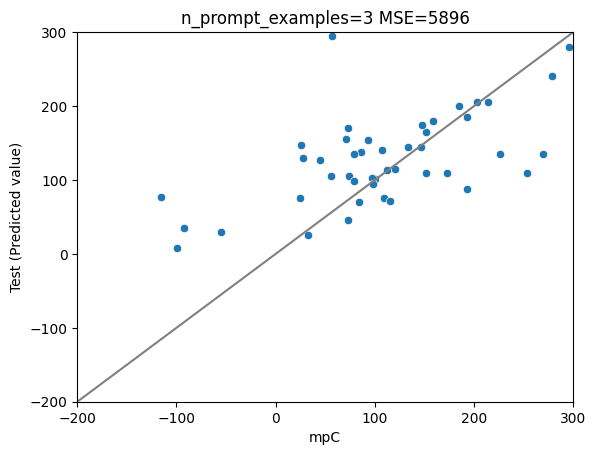

In [ ]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [ ]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


5895.850222222222
54.964444444444446
0.30817339249534215


In [ ]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.9